In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline


%matplotlib inline
sns.set(style="whitegrid")

path = "../fake_job_postings.csv"
df = pd.read_csv(path)

df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [33]:
print("Shape:", df.shape)
print("\nDtypes:")
print(df.dtypes)

print("\nTarget value_counts:")
print(df["fraudulent"].value_counts(normalize=True))

print("\nColumns:")
print(df.columns.tolist())

Shape: (17880, 18)

Dtypes:
job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

Target value_counts:
fraudulent
0    0.951566
1    0.048434
Name: proportion, dtype: float64

Columns:
['job_id', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent']


In [34]:
df.isna().mean().sort_values(ascending=False).head(20)

salary_range           0.839597
department             0.645805
required_education     0.453300
benefits               0.403356
required_experience    0.394295
function               0.361018
industry               0.274217
employment_type        0.194128
company_profile        0.185011
requirements           0.150783
location               0.019351
description            0.000056
job_id                 0.000000
telecommuting          0.000000
has_questions          0.000000
has_company_logo       0.000000
title                  0.000000
fraudulent             0.000000
dtype: float64

In [35]:
num_cols_basic = ["telecommuting", "has_company_logo", "has_questions"]
df[num_cols_basic].describe()

,telecommuting,has_company_logo,has_questions
count,17880.000000,17880.000000,17880.000000
mean,0.042897,0.795302,0.491723
std,0.202631,0.403492,0.499945
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000
50%,0.000000,1.000000,0.000000
75%,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


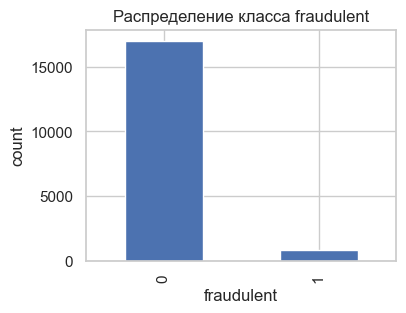

In [36]:
plt.figure(figsize=(4,3))
df["fraudulent"].value_counts().plot(kind="bar")
plt.title("Распределение класса fraudulent")
plt.xlabel("fraudulent")
plt.ylabel("count")
plt.show()

По графику видно, что класс `0` (реальные вакансии) сильно преобладает над `1` (фейковые) — имеется несбалансированность классов.

In [37]:
text_cols = ["title", "company_profile", "description", "requirements", "benefits"]

cat_cols = [
    "location", "department", "employment_type",
    "required_experience", "required_education",
    "industry", "function"
]

num_cols = ["telecommuting", "has_company_logo", "has_questions"]

# Обработка пропусков
df[text_cols] = df[text_cols].fillna("")
df[cat_cols] = df[cat_cols].fillna("Unknown")
df[num_cols] = df[num_cols].fillna(0)

df[text_cols + cat_cols + num_cols].isna().sum()

title                  0
company_profile        0
description            0
requirements           0
benefits               0
location               0
department             0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
telecommuting          0
has_company_logo       0
has_questions          0
dtype: int64

В моделях мы будем использовать One-Hot Encoding для `cat_cols`.

KNN использует расстояния, поэтому числовые признаки нужно нормализовать.  
Мы будем применять `StandardScaler` и `OneHotEncoder`

In [38]:
for col in text_cols:
    df[col + "_len"] = df[col].str.len()

len_cols = [c + "_len" for c in text_cols]

def parse_salary_min(x):
    try:
        return float(str(x).split("-")[0])
    except Exception:
        return np.nan

def parse_salary_max(x):
    try:
        return float(str(x).split("-")[-1])
    except Exception:
        return np.nan

df["salary_min"] = df["salary_range"].apply(parse_salary_min)
df["salary_max"] = df["salary_range"].apply(parse_salary_max)

for c in ["salary_min", "salary_max"]:
    df[c] = df[c].fillna(df[c].median())

salary_cols = ["salary_min", "salary_max"]

num_features = num_cols + len_cols + salary_cols

df[num_features].describe().T.head()

,count,mean,std,min,25%,50%,75%,max
telecommuting,17880.0,0.042897,0.202631,0.0,0.0,0.0,0.0,1.0
has_company_logo,17880.0,0.795302,0.403492,0.0,1.0,1.0,1.0,1.0
has_questions,17880.0,0.491723,0.499945,0.0,0.0,0.0,1.0,1.0
title_len,17880.0,28.530313,13.871256,3.0,19.0,25.0,35.0,142.0
company_profile_len,17880.0,620.901454,567.454100,0.0,138.0,570.0,879.0,6178.0


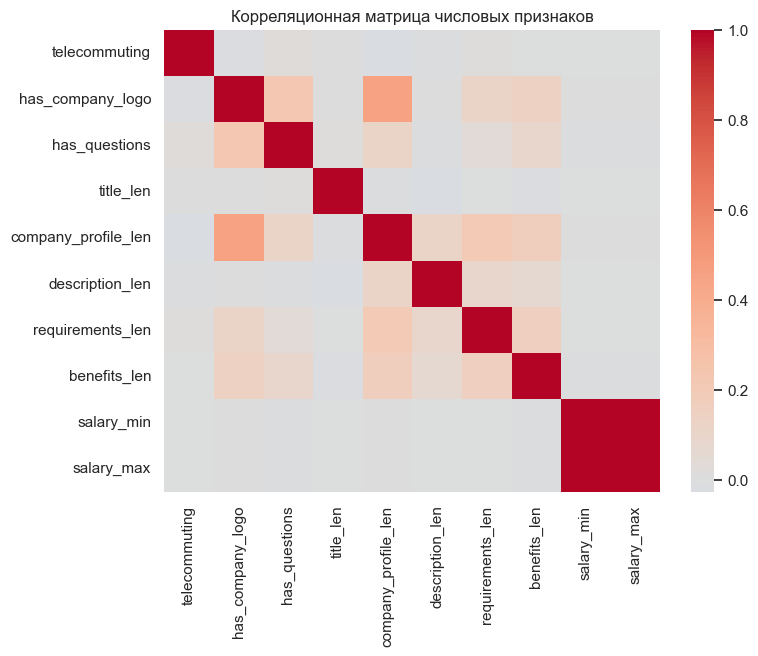

salary_min             1.000000
salary_max             0.999388
company_profile_len    0.007914
has_company_logo       0.004877
telecommuting         -0.001900
requirements_len      -0.002066
title_len             -0.002789
description_len       -0.002876
benefits_len          -0.006049
has_questions         -0.010160
Name: salary_min, dtype: float64

In [39]:
corr = df[num_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Корреляционная матрица числовых признаков")
plt.show()

corr["salary_min"].sort_values(ascending=False).head(10)

In [ ]:
df["salary_mean"] = (df["salary_min"] + df["salary_max"]) / 2

num_features_model = num_cols + len_cols + ["salary_mean"]

num_features_model

['telecommuting',
 'has_company_logo',
 'has_questions',
 'title_len',
 'company_profile_len',
 'description_len',
 'requirements_len',
 'benefits_len',
 'salary_mean']

In [41]:
from sklearn.model_selection import train_test_split

feature_cols = cat_cols + num_features_model
target_col = "fraudulent"

X = df[feature_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape, y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

((14304, 16),
 (3576, 16),
 fraudulent
 0    0.951552
 1    0.048448
 Name: proportion, dtype: float64,
 fraudulent
 0    0.951622
 1    0.048378
 Name: proportion, dtype: float64)

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features_model),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

knn_clf = KNeighborsClassifier()

knn_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", knn_clf),
])

param_grid = {
    "model__n_neighbors": [3, 5, 7, 9, 11, 15],
    "model__weights": ["uniform", "distance"],
}

knn_grid = GridSearchCV(
    knn_pipe,
    param_grid,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
)

knn_grid.fit(X_train, y_train)

print("Лучшие параметры:", knn_grid.best_params_)
print("Лучший средний F1 по CV:", knn_grid.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Лучшие параметры: {'model__n_neighbors': 3, 'model__weights': 'distance'}
Лучший средний F1 по CV: 0.7055053688451324


In [43]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

def evaluate_model(model, X_train, y_train, X_test, y_test, name="model"):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Предсказанные вероятности для ROC-AUC (если доступны)
    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
        train_auc = roc_auc_score(y_train, y_train_proba)
        test_auc = roc_auc_score(y_test, y_test_proba)
    else:
        train_auc = test_auc = None
    
    print(f"=== {name} ===")
    print("Train accuracy:", accuracy_score(y_train, y_train_pred))
    print("Test  accuracy:", accuracy_score(y_test, y_test_pred))
    if train_auc is not None:
        print("Train ROC-AUC:", train_auc)
        print("Test  ROC-AUC:", test_auc)
    print("\nClassification report (test):\n", classification_report(y_test, y_test_pred))
    print("Confusion matrix (test):\n", confusion_matrix(y_test, y_test_pred))
    print("-" * 60)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", KNeighborsClassifier())
])

param_grid_knn = {
    "model__n_neighbors": [3, 5, 7, 11, 15, 21],
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2], 
}

grid_knn = GridSearchCV(
    knn_pipe,
    param_grid_knn,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1,
)

grid_knn.fit(X_train, y_train)

print("Лучшие параметры kNN:", grid_knn.best_params_)
print("Лучший ROC-AUC (CV):", grid_knn.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Лучшие параметры kNN: {'model__n_neighbors': 21, 'model__p': 1, 'model__weights': 'distance'}
Лучший ROC-AUC (CV): 0.9541226045524039


In [45]:
best_knn = grid_knn.best_estimator_
evaluate_model(best_knn, X_train, y_train, X_test, y_test, name="kNN (best)")

=== kNN (best) ===
Train accuracy: 1.0
Test  accuracy: 0.977069351230425
Train ROC-AUC: 1.0
Test  ROC-AUC: 0.9481586291592424

Classification report (test):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.89      0.60      0.72       173

    accuracy                           0.98      3576
   macro avg       0.93      0.80      0.85      3576
weighted avg       0.98      0.98      0.97      3576

Confusion matrix (test):
 [[3390   13]
 [  69  104]]
------------------------------------------------------------


Для kNN мы подобрали число соседей `n_neighbors`, тип весов (`uniform` / `distance`) 
и параметр `p` метрики (1 — манхэттен, 2 — евклидово расстояние) по метрике ROC-AUC с 3‑кратной кросс‑валидацией.

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1,
    )),
])

param_grid_logreg = {
    "model__C": [0.1, 1.0, 3.0, 10.0],
}

grid_logreg = GridSearchCV(
    logreg_pipe,
    param_grid_logreg,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1,
)

grid_logreg.fit(X_train, y_train)

print("Лучшие параметры логистической регрессии:", grid_logreg.best_params_)
print("Лучший ROC-AUC (CV):", grid_logreg.best_score_)

best_logreg = grid_logreg.best_estimator_
evaluate_model(best_logreg, X_train, y_train, X_test, y_test, name="LogisticRegression (balanced)")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Лучшие параметры логистической регрессии: {'model__C': 1.0}
Лучший ROC-AUC (CV): 0.9425044869170943
=== LogisticRegression (balanced) ===
Train accuracy: 0.9374300894854586
Test  accuracy: 0.930089485458613
Train ROC-AUC: 0.9880653147128792
Test  ROC-AUC: 0.9568384917082682

Classification report (test):
               precision    recall  f1-score   support

           0       0.99      0.93      0.96      3403
           1       0.40      0.84      0.54       173

    accuracy                           0.93      3576
   macro avg       0.69      0.89      0.75      3576
weighted avg       0.96      0.93      0.94      3576

Confusion matrix (test):
 [[3180  223]
 [  27  146]]
------------------------------------------------------------


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1,
    )),
])

param_grid_rf = {
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_leaf": [1, 3, 5],
}

grid_rf = GridSearchCV(
    rf_pipe,
    param_grid_rf,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1,
)

grid_rf.fit(X_train, y_train)

print("Лучшие параметры RandomForest:", grid_rf.best_params_)
print("Лучший ROC-AUC (CV):", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_
evaluate_model(best_rf, X_train, y_train, X_test, y_test, name="RandomForest (balanced_subsample)")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Лучшие параметры RandomForest: {'model__max_depth': None, 'model__min_samples_leaf': 1}
Лучший ROC-AUC (CV): 0.9841414554881603
=== RandomForest (balanced_subsample) ===
Train accuracy: 1.0
Test  accuracy: 0.9801454138702461
Train ROC-AUC: 0.9999999999999999
Test  ROC-AUC: 0.9861895063689128

Classification report (test):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.99      0.60      0.74       173

    accuracy                           0.98      3576
   macro avg       0.99      0.80      0.87      3576
weighted avg       0.98      0.98      0.98      3576

Confusion matrix (test):
 [[3402    1]
 [  70  103]]
------------------------------------------------------------


In [48]:
models = {
    "kNN": best_knn,
    "LogReg": best_logreg,
    "RandomForest": best_rf,
}

summary = []

for name, model in models.items():
    y_test_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_test_proba)
    acc = accuracy_score(y_test, model.predict(X_test))
    summary.append((name, acc, auc))

summary

[('kNN', 0.977069351230425, 0.9481586291592424),
 ('LogReg', 0.930089485458613, 0.9568384917082682),
 ('RandomForest', 0.9801454138702461, 0.9861895063689128)]

In [49]:
corr_matrix = df[num_features].corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print("Сильно коррелированные признаки к удалению:", to_drop)

num_features_uncorr = [c for c in num_features if c not in to_drop]
num_features_uncorr

Сильно коррелированные признаки к удалению: ['salary_max']


['telecommuting',
 'has_company_logo',
 'has_questions',
 'title_len',
 'company_profile_len',
 'description_len',
 'requirements_len',
 'benefits_len',
 'salary_min']

## Общие выводы

**Разведочный анализ (EDA).**
   - Размер датасета: ~18k строк и 18 столбцов.
   - Целевая переменная сильно несбалансирована: около 95% реальных вакансий и 5% фейковых.
   - В текстовых и категориальных столбцах много пропусков; в бинарных (`telecommuting`, `has_company_logo`, `has_questions`) 
     распределения близки к 0/1.
   - По длинам текстов и зарплатам видно, что фейковые вакансии часто имеют менее детализированные описания и аномальные зарплаты.

**Предобработка.**
   - Пропуски в текстах заменены на пустые строки, в категориальных — на фиксированное значение `"Unknown"`, 
     в числовых — на 0 или медиану (для зарплат).
   - Категориальные признаки кодируются через One-Hot Encoding.
   - Числовые признаки (включая длины текстов и числовые признаки по зарплате) нормализуются с помощью `StandardScaler`.

**Коррелированные признаки.**
   - Признаки `salary_min` и `salary_max` имеют очень высокую корреляцию.
   - Чтобы уменьшить мультиколлинеарность, из числовых признаков был исключён `salary_max`, а в моделях использовался только `salary_min`.

**Модели и результаты.**
   - Модель k‑ближайших соседей (kNN) после подбора гиперпараметров (`n_neighbors=21`, `weights="distance"`, `p=1`) показала высокое качество: 
     accuracy на тесте около 0.98, ROC‑AUC около 0.95. При этом на трейне качество почти идеально (1.0), что говорит о заметном переобучении.
   - Логистическая регрессия с `class_weight="balanced"` даёт accuracy на тесте около 0.93 и ROC‑AUC около 0.96. 
     Она значительно повышает полноту по классу `1` (фейковые вакансии, recall ~0.84), но делает это ценой меньшей точности по этому классу.
   - Random Forest с `class_weight="balanced_subsample"` даёт наилучшее качество среди рассмотренных моделей: 
     accuracy на тесте около 0.98 и ROC‑AUC около 0.99. Полнота по классу `1` сопоставима с kNN (~0.60), 
     но при этом модель более устойчива и лучше захватывает нелинейные зависимости.

**Дисбаланс классов.**
   - Простая accuracy плохо отражает качество из‑за большого числа объектов класса `0`.
   - Для борьбы с дисбалансом использовались: стратифицированное разбиение train/test (`stratify=y`), 
     веса классов (`class_weight="balanced"` и `"balanced_subsample"`) и метрика ROC‑AUC при подборе гиперпараметров.
   - По ROC‑AUC и матрицам ошибок видно, что логистическая регрессия лучше всего находит фейковые вакансии по полноте, 
     а Random Forest обеспечивает одновременно высокую общую точность и очень высокий ROC‑AUC.

**Итоговый вывод.**
 - Для максимального ROC‑AUC и общей точности, в качестве итоговой модели разумно выбрать Random Forest
 - Для минимизации пропусков фейковых вакансий лучше конечно выбрать логистическую регрессию